# Variance test for the  Cool multi-task GP

### Notebook description

This notebook runs the variance test experiment present in the supplementary material of the paper. To run the full experiment, the user must first install the GPFlow and GPyTorch libraries. The notebook can be executed without them installed, although their results will be missing.

### Dataset description

The synthetic dataset is generated by a pair of trigonimetric functions of one input dimension to produce two related tasks. Then, the signal is contaminated with additive Gaussian noise featuring a full covariance matrix. Three options to generate the input variables are provided:
- Linear: input data will be a linear sequence of values between 0 and 1. 
- Random: input data will be a set of samples from a uniform distribution between 0 and 1.
- Clustered: the input data will clump around two distinct centers, located between 0 and 1.

In [46]:
import os
# Prevent weird error (exclusive to MacOS)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import copy
import math
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import inv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.datasets import make_blobs as blobs
from sklearn.metrics.pairwise import rbf_kernel

from lib.kernels import WhiteKernel
from lib.kernels import RBF
from lib.A_Cool_MTGP import MultitaskGP as a_mtgp
from lib.H_Cool_MTGP import MultitaskGP as h_mtgp
from lib.coolmt_gptorch import Cool_MTGP as torch_mtgp

try:
    import gpflow as gpf
    import tensorflow as tf
    from gpflow.utilities import print_summary
    from gpflow.ci_utils import ci_niter
    GPFlow = True
except:
    print('GPFlow not installed.')
    GPFlow = False

try:
    import torch
    import gpytorch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    GPTorch = True
except:
    print('GPTorch not installed.')
    GPFlow = False

%matplotlib inline
%load_ext autoreload
%autoreload 2

def plot_results(X_tr, Y_tr, X_tst, mean, lower, upper, Y_tst=None, model=None):
    ''' Plotting function.'''
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    ax1.fill_between(X_tst.squeeze(), lower[:, 0], upper[:, 0], alpha=0.3, label='Confidence interval')
    if Y_tst is not None:
        ax1.scatter(X_tst, Y_tst[:, 0], c='darkorange', marker='*', label='Test Data')
    ax1.scatter(X_tr, Y_tr[:, 0], c='k', marker='*', label='Observed Data')
    ax1.plot(X_tst, mean[:, 0], 'b')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([-3, 3])
    ax1.legend()
    ax1.set_title('Task 1')
    
    ax2.fill_between(X_tst.squeeze(), lower[:, 1], upper[:, 1], alpha=0.3, label='Confidence interval')
    if Y_tst is not None:
        ax2.scatter(X_tst, Y_tst[:, 1], c='darkorange', marker='*', label='Test Data')
    ax2.scatter(X_tr, Y_tr[:, 1], c='k', marker='*', label='Observed Data')
    ax2.plot(X_tst, mean[:, 1], 'b')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([-3, 3])
    ax2.legend()
    ax2.set_title('Task 2')
    
    if model is not None:
        f.suptitle(model)
        f.savefig(f'{model}_confidence.png', dpi=200)
    
def n_sigma(mean, Y_tst, lower, upper, n=2):
    '''Compute confidence interval.'''
    cov = (upper - mean)/2
    _lower = mean - cov * n
    _upper = mean + cov * n
    Y_tst_m = copy.copy(Y_tst)
    idx = Y_tst > mean
    Y_tst_m[idx] = -(Y_tst[idx] - mean[idx]) + mean[idx]
    sigma = (sum(Y_tst_m  > _lower))/Y_tst.shape[0]
    return sigma

Running on cpu.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


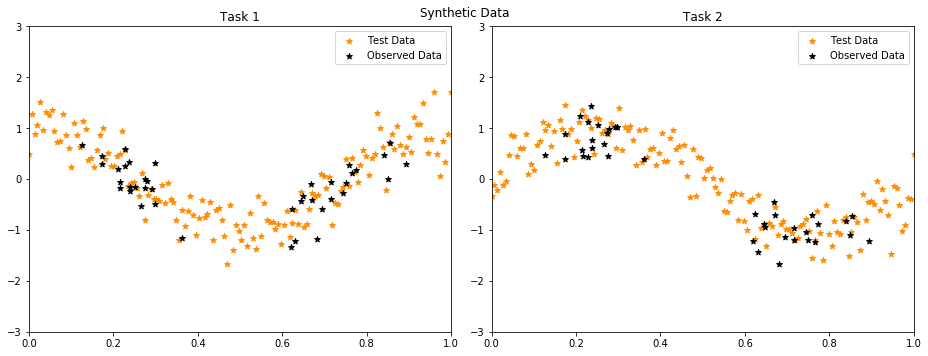

In [15]:
# GENERATE DATA
# Trigonometric functions with correlated additive noise.

np.random.seed(15)
train_mode = 'clustered' # 'linear', 'random' or 'clustered'
noise_mean = [0, 0]
noise_sigma = np.array([[0.1, 0.05],
                        [0.05, 0.1]])
n_tr = 40
n_tst = 150

if train_mode == 'linear':
    X_tr = np.linspace(0, 1, n_tr)[:, np.newaxis]
elif train_mode == 'random':
    X_tr = np.random.uniform(0, 1, n_tr)[:, np.newaxis]
elif train_mode == 'clustered':
    centers = np.array([0.25, 0.75]).reshape((2, 1))
    X_tr, _ = blobs(n_samples=n_tr, 
                    n_features=1, 
                    centers=centers, 
                    cluster_std=0.07, 
                    center_box=(0, 1))
X_tst = np.linspace(0, 1, n_tst)[:, np.newaxis]

Y_tr_signal = np.hstack((np.cos(X_tr * (2 * math.pi)), 
                         np.sin(X_tr * (2 * math.pi))))
Y_tr_noise = mvn.rvs(mean=noise_mean,
                     cov=noise_sigma, 
                     size=n_tr, 
                     random_state=None)
Y_tr = Y_tr_signal + Y_tr_noise

Y_tst_signal = np.hstack((np.cos(X_tst * (2 * math.pi)), 
                          np.sin(X_tst * (2 * math.pi))))
Y_tst_noise = mvn.rvs(mean=noise_mean, 
                      cov=noise_sigma, 
                      size=n_tst, 
                      random_state=None)
Y_tst = Y_tst_signal + Y_tst_noise

if GPTorch:
    # Convert numpy arrays to torch tensors.
    X_tr_tens = torch.from_numpy(X_tr).float().to(device)
    Y_tr_tens = torch.from_numpy(Y_tr).float().to(device)
    X_tst_tens = torch.from_numpy(X_tst).float().to(device)

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.scatter(X_tst, Y_tst[:, 0], c='darkorange', marker='*', label='Test Data')
ax1.scatter(X_tr, Y_tr[:, 0], c='k', marker='*', label='Observed Data')
ax1.set_xlim([0, 1])
ax1.set_ylim([-3, 3])
ax1.legend()
ax1.set_title('Task 1')

ax2.scatter(X_tst, Y_tst[:, 1], c='darkorange', marker='*', label='Test Data')
ax2.scatter(X_tr, Y_tr[:, 1], c='k', marker='*', label='Observed Data')
ax2.set_xlim([0, 1])
ax2.set_ylim([-3, 3])
ax2.legend()
ax2.set_title('Task 2')

fig.suptitle('Synthetic Data')
fig.tight_layout()

In [16]:
# STD-MTGP

if GPTorch:
    class MultitaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.MultitaskMean(
                gpytorch.means.ConstantMean(), num_tasks=2
            )
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(X_tr_tens, Y_tr_tens, likelihood)

    # Find optimal model hyperparameters
    training_iterations = 50
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(X_tr_tens)
        loss = -mll(output, Y_tr_tens)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(X_tst_tens))
        mean_std = predictions.mean
        lower_std, upper_std = predictions.confidence_region()
        mse_std = MSE(Y_tst, mean_std)

    # Get estimated matrices
    noise_std = model.likelihood.noise.item()
    B = model.covar_module.task_covar_module.covar_factor.detach().numpy()
    v = model.covar_module.task_covar_module.raw_var.detach().numpy()
    C_std = B @ B.T + np.diag(v)
    Sigma_std = noise_std * np.eye(2)
    std_lengthscale = model.covar_module.data_covar_module.lengthscale.item()

In [17]:
# CONV-MTGP

if GPFlow:
    MAXITER = ci_niter(1000)
    def optimize_model_with_scipy(model, tr_data):
        optimizer = gpf.optimizers.Scipy()
        optimizer.minimize(model.training_loss_closure(tr_data),
                           variables=model.trainable_variables,
                           method="l-bfgs-b",
                           options={"disp": True, "maxiter": MAXITER},)

    kernel = gpf.kernels.SharedIndependent(gpf.kernels.SquaredExponential(), output_dim=2)

    ratio_indp = 0.15
    M = int(n_tr*ratio_indp) # number of induction points

    Zidx = np.random.randint(0, n_tr, size=M)
    Zinit = X_tr[Zidx] # initialize induction points from the training set
    Z = Zinit.copy()

    iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))

    tr_data = (X_tr, Y_tr)
    model = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=2)
    optimize_model_with_scipy(model, tr_data)
    mean_conv, cov = model.predict_y(X_tst)
    mse_conv = MSE(Y_tst, mean_conv)

    lower_conv = mean_conv - 2*np.sqrt(cov)
    upper_conv = mean_conv + 2*np.sqrt(cov)

In [18]:
# HCOOL-mtGP_hcool

# Initialise kernels for the Cool-mtGP_hcool
kernel_X = RBF(1.0, (1e-2, 1e2))
kernel_noise = WhiteKernel(1, (1e-30, 1000))

mtGP_hcool = h_mtgp(kernel=kernel_X, kernel_noise=kernel_noise, n_restarts_optimizer=15)
mtGP_hcool.fit(X_tr, Y_tr, alpha_method ='largeT')
mean_hcool, lower_hcool, upper_hcool = mtGP_hcool.predict(X_tst, conf_intervals=True)
mse_hcool = MSE(Y_tst, mean_hcool)

In [19]:
# ~COOL-mtGP_acool

# Initialise kernels for the Cool-mtGP_acool
kernel_X = RBF(1.0, (1e-2, 1e2))
kernel_noise = WhiteKernel(1, (1e-30, 1000))

mtGP_acool = a_mtgp(kernel=kernel_X, kernel_noise=kernel_noise, n_restarts_optimizer=15)
mtGP_acool.fit(X_tr, Y_tr)
mean_acool, lower_acool, upper_acool = mtGP_acool.predict(X_tst, conf_intervals=True)
mse_acool = MSE(Y_tst, mean_acool)

In [47]:
# Torch COOL

cool_torch = torch_mtgp(kernel='RBF')
cool_torch.train(X_tr_tens, Y_tr_tens, training_iter=100, verbose=False)
mean_torchcool, covar_data = cool_torch.predict(X_tst_tens, conf_intervals=True)
lower_torchcool = covar_data['lower']
upper_torchcool = covar_data['upper']
mse_torchcool = MSE(Y_tst, mean_torchcool)

Training model...
Iteration 0 of 1.
Updating model...


In [48]:
# RESULT SUMMARY

one_sigma_std = n_sigma(mean_std.numpy(), Y_tst, lower_std.numpy(), upper_std.numpy(), n=1)
one_sigma_conv = n_sigma(mean_conv.numpy(), Y_tst, lower_conv.numpy(), upper_conv.numpy(), n=1)
one_sigma_hcool = n_sigma(mean_hcool, Y_tst, lower_hcool, upper_hcool, n=1)
one_sigma_acool = n_sigma(mean_acool, Y_tst, lower_acool, upper_acool, n=1)
one_sigma_torchcool = n_sigma(mean_torchcool, Y_tst, lower_torchcool, upper_torchcool, n=1)

two_sigma_std = n_sigma(mean_std.numpy(), Y_tst, lower_std.numpy(), upper_std.numpy(), n=2)
two_sigma_conv = n_sigma(mean_conv.numpy(), Y_tst, lower_conv.numpy(), upper_conv.numpy(), n=2)
two_sigma_hcool = n_sigma(mean_hcool, Y_tst, lower_hcool, upper_hcool, n=2)
two_sigma_acool = n_sigma(mean_acool, Y_tst, lower_acool, upper_acool, n=2)
two_sigma_torchcool = n_sigma(mean_torchcool, Y_tst, lower_torchcool, upper_torchcool, n=2)

print('RESULT SUMMARY\n')
print("Mean squared error scores:\n")
print(f"    Std-MT: {mse_std:.4f}")
print(f"    Conv-MT: {mse_conv:.4f}")
print(f"    ~Cool-MT: {mse_acool:.4f}")
print(f"    HCool-MT: {mse_hcool:.4f}")
print(f"    Torch Cool-MT: {mse_torchcool:.4f}")

print("\nOne Sigma values:\n")
print(f"    Std-MT: task 1 = {one_sigma_std[0]:.2f}, task 2 = {one_sigma_std[1]:.2f}")
print(f"    Conv-MT: task 1 = {one_sigma_conv[0]:.2f}, task 2 = {one_sigma_conv[1]:.2f}")
print(f"    ~Cool-MT: task 1 = {one_sigma_acool[0]:.2f}, task 2 = {one_sigma_acool[1]:.2f}")
print(f"    HCool-MT: task 1 = {one_sigma_hcool[0]:.2f}, task 2 = {one_sigma_hcool[1]:.2f}")
print(f"    Torch Cool-MT: task 1 = {one_sigma_torchcool[0]:.2f}, task 2 = {one_sigma_torchcool[1]:.2f}")

print("\nTwo Sigma values:\n")
print(f"    Std-MT: task 1 = {two_sigma_std[0]:.2f}, task 2 = {two_sigma_std[1]:.2f}")
print(f"    Conv-MT: task 1 = {two_sigma_conv[0]:.2f}, task 2 = {two_sigma_conv[1]:.2f}")
print(f"    ~Cool-MT: task 1 = {two_sigma_acool[0]:.2f}, task 2 = {two_sigma_acool[1]:.2f}")
print(f"    HCool-MT: task 1 = {two_sigma_hcool[0]:.2f}, task 2 = {two_sigma_hcool[1]:.2f}")
print(f"    Torch Cool-MT: task 1 = {two_sigma_torchcool[0]:.2f}, task 2 = {two_sigma_torchcool[1]:.2f}")

RESULT SUMMARY

Mean squared error scores:

    Std-MT: 0.1673
    Conv-MT: 0.1563
    ~Cool-MT: 0.1437
    HCool-MT: 0.1437
    Torch Cool-MT: 0.1265

One Sigma values:

    Std-MT: task 1 = 0.66, task 2 = 0.56
    Conv-MT: task 1 = 0.67, task 2 = 0.62
    ~Cool-MT: task 1 = 0.67, task 2 = 0.61
    HCool-MT: task 1 = 0.67, task 2 = 0.61
    Torch Cool-MT: task 1 = 0.67, task 2 = 0.52

Two Sigma values:

    Std-MT: task 1 = 0.92, task 2 = 0.93
    Conv-MT: task 1 = 0.93, task 2 = 0.97
    ~Cool-MT: task 1 = 0.95, task 2 = 0.97
    HCool-MT: task 1 = 0.95, task 2 = 0.97
    Torch Cool-MT: task 1 = 0.95, task 2 = 0.93


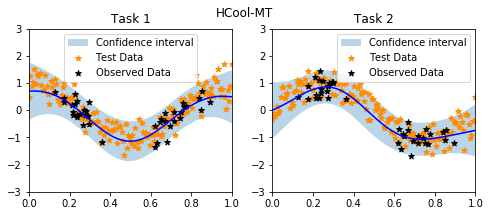

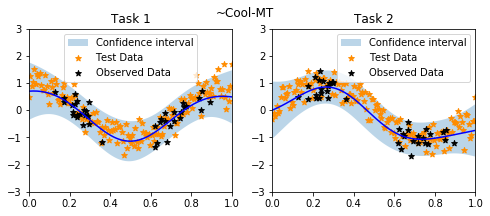

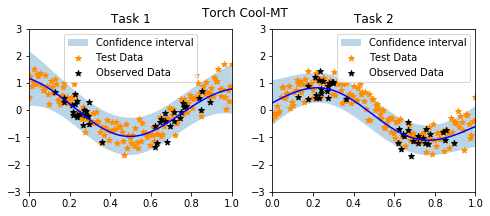

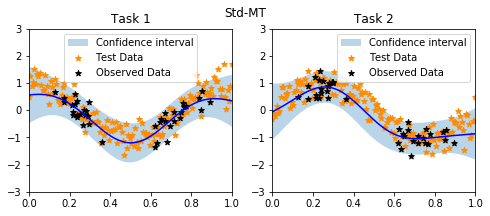

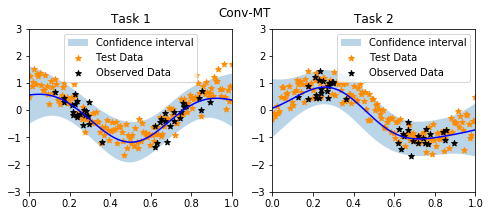

In [49]:
# PLOT SINGLE TASK CONFIDENCE INTERVALS

plot_results(X_tr, Y_tr, X_tst, 
             mean_hcool, 
             lower_hcool, 
             upper_hcool, 
             Y_tst=Y_tst,
             model='HCool-MT')

plot_results(X_tr, Y_tr, X_tst, 
             mean_acool, 
             lower_acool,
             upper_acool,
             Y_tst=Y_tst,
             model='~Cool-MT')

plot_results(X_tr, Y_tr, X_tst, 
             mean_torchcool, 
             lower_torchcool,
             upper_torchcool,
             Y_tst=Y_tst,
             model='Torch Cool-MT')

if GPTorch:
    plot_results(X_tr, Y_tr, X_tst, 
                 mean_std.numpy(), 
                 lower_std.numpy(), 
                 upper_std.numpy(), 
                 Y_tst=Y_tst, 
                 model='Std-MT')

if GPFlow:
    plot_results(X_tr, Y_tr, X_tst, 
                 mean_conv, 
                 lower_conv, 
                 upper_conv, 
                 Y_tst=Y_tst,
                 model='Conv-MT')

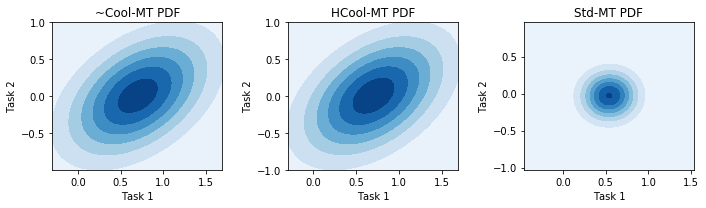

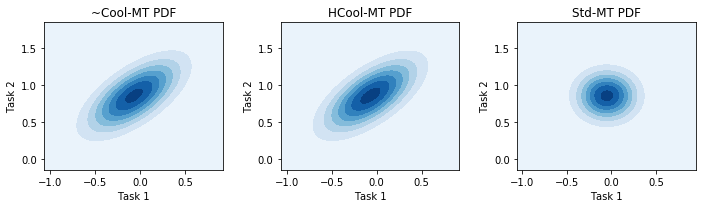

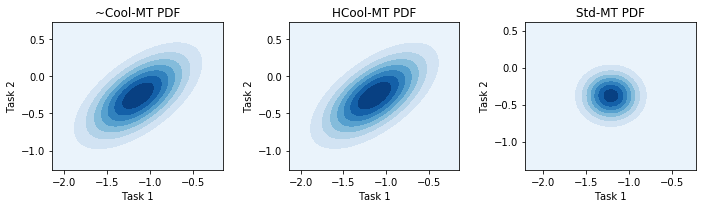

In [9]:
# PLOT PREDICTIVE POSTERIOR PDFs FOR A FEW SAMPLES

idxs = [0, 38, 75]
cmap = 'Blues'

C_hcool = mtGP_hcool._PriorW
Sigma_hcool = mtGP_hcool._SigmaTT
C_acool = mtGP_acool._PriorW
Sigma_acool = mtGP_acool._SigmaTT

K_tr_hcool = mtGP_hcool.compute_kernel(X_tr, X_tr)
K_tr_acool = mtGP_acool.compute_kernel(X_tr, X_tr)
K_tr_std = rbf_kernel(X_tr, gamma=std_lengthscale)
C_K_tr_hcool = np.kron(C_hcool, K_tr_hcool)
C_K_tr_acool = np.kron(C_acool, K_tr_acool)
C_K_tr_std = np.kron(C_std, K_tr_std)
Sigma_I_hcool = np.kron(Sigma_hcool, np.eye(n_tr))
Sigma_I_acool = np.kron(Sigma_acool, np.eye(n_tr))
if GPTorch:
    Sigma_I_std = np.kron(Sigma_std, np.eye(n_tr))
Inverse_hcool = inv(C_K_tr_hcool + Sigma_I_hcool)
Inverse_acool = inv(C_K_tr_acool + Sigma_I_acool)
Inverse_std = inv(C_K_tr_std + Sigma_I_std)

for idx in idxs:

    K_tr_test_acool = mtGP_acool.compute_kernel(X_tr, X_tst[idx, :][np.newaxis, :])
    K_test_acool = mtGP_acool.compute_kernel(X_tst[idx, :][np.newaxis, :], X_tst[idx, :][np.newaxis, :])
    C_K_tr_test = np.kron(C_acool, K_tr_test_acool)
    C_K_test = np.kron(C_acool, K_test_acool)
    pred_sigma_acool = C_K_test - C_K_tr_test.T @ Inverse_acool @ C_K_tr_test + Sigma_acool
    rv_acool = mvn(mean_acool[idx, :], pred_sigma_acool)
        
    K_tr_test_hcool = mtGP_hcool.compute_kernel(X_tr, X_tst[idx, :][np.newaxis, :])
    K_test_hcool = mtGP_hcool.compute_kernel(X_tst[idx, :][np.newaxis, :], X_tst[idx, :][np.newaxis, :])
    C_K_tr_test = np.kron(C_hcool, K_tr_test_hcool)
    C_K_test = np.kron(C_hcool, K_test_hcool)
    pred_sigma_hcool = C_K_test - C_K_tr_test.T @ Inverse_hcool @ C_K_tr_test + Sigma_hcool
    rv_hcool = mvn(mean_hcool[idx, :], pred_sigma_hcool)
    
    if GPTorch:
        K_tr_test_std = rbf_kernel(X_tr, X_tst[idx, :][np.newaxis, :], gamma=std_lengthscale)
        K_test_std = rbf_kernel(X_tst[idx, :][np.newaxis, :], X_tst[idx, :][np.newaxis, :], gamma=std_lengthscale)
        C_K_tr_test = np.kron(C_std, K_tr_test_std)
        C_K_test = np.kron(C_std, K_test_std)
        sub_cov = C_K_test - C_K_tr_test.T @ Inverse_std @ C_K_tr_test + Sigma_std    
        pred_sigma_std = (sub_cov + sub_cov.T)/2 + np.eye(2)*10e-12
        rv_std = mvn(mean_std[idx, :], pred_sigma_std)
    
    # Plots
    if GPTorch:
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(17, 3))
    
    x, y = np.mgrid[mean_acool[idx, 0] - 1:mean_acool[idx, 0] + 1:.01, 
                    mean_acool[idx, 1] - 1:mean_acool[idx, 1] + 1:.01]
    pos = np.dstack((x, y))
    axes[0].contourf(x, y, rv_acool.pdf(pos), cmap=cmap)
    axes[0].set_title('~Cool-MT PDF')
    axes[0].set_xlabel('Task 1')
    axes[0].set_ylabel('Task 2')
    
    x, y = np.mgrid[mean_hcool[idx, 0] - 1:mean_hcool[idx, 0] + 1:.01, 
                    mean_hcool[idx, 1] - 1:mean_hcool[idx, 1] + 1:.01]
    pos = np.dstack((x, y))
    axes[1].contourf(x, y, rv_hcool.pdf(pos), cmap=cmap)
    axes[1].set_title('HCool-MT PDF')
    axes[1].set_xlabel('Task 1')
    axes[1].set_ylabel('Task 2')
    
    if GPTorch:
        x, y = np.mgrid[mean_std.numpy()[idx, 0] - 1:mean_std.numpy()[idx, 0] + 1:.01, 
                        mean_std.numpy()[idx, 1] - 1:mean_std.numpy()[idx, 1] + 1:.01]
        pos = np.dstack((x, y))
        axes[2].contourf(x, y, rv_std.pdf(pos), cmap=cmap)
        axes[2].set_title('Std-MT PDF')
        axes[2].set_xlabel('Task 1')
        axes[2].set_ylabel('Task 2')
    
    fig.tight_layout()
    fig.savefig(f'Sample_{idx}.png', dpi=200)

### Conclusions

As can be seen in the figures, all models arrive at similar task-wise confidence intervals. However, analysing the complete predictive posterior we can appreciate clear differences:


- To the best of our knowledge, Conv-MTGP cannot compute a complete predictive distribution.
- While Std-MTGP does offer a full predictive distribution, it considers the noise to be indepentend among tasks. Therefore its predictive distribution tends to be almost spherical.
- Both versions of Cool-MTGP produce predictive posteriors that adequately model the correlation among tasks with a full covariance matrix.
- There is little appreciable difference between HCool-MTGP and ~Cool-MTGP. 
